## Parameter Setup

In [1]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

/usr/local/lib/python3.8/dist-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-04-21 07:20:40.013068: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 07:20:40.152104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2

(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>
(64, 64, 1) <class 'deeptrack.image.Image'>


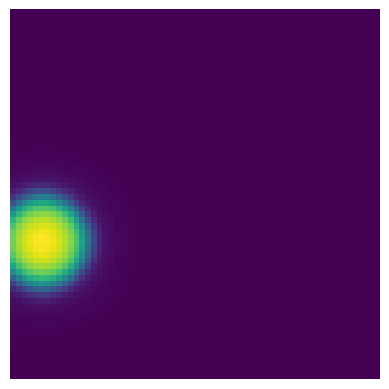

In [2]:
dataset.update()
images = dataset()
# The first entry contains all frames in a big tensor, the rest of the entries is each frame
for img in images[1:]:
    print(img.shape, type(img))
dataset.plot()

## Auto Encoder

In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Layer

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
    
    def build(self, _):
        self.weights_linear = self.add_weight(name="weight_linear", shape=(int(self.seq_len),), initializer="uniform", trainable=True)
        self.bias_linear = self.add_weight(name="bias_linear", shape=(int(self.seq_len),), initializer="uniform", trainable=True)
        self.weights_periodic = self.add_weight(name="weight_periodic", shape=(int(self.seq_len),), initializer="uniform", trainable=True)
        self.bias_periodic = self.add_weight(name="bias_periodic", shape=(int(self.seq_len),), initializer="uniform", trainable=True)
        
    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1)
        
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)
        
        return tf.concat([time_linear, time_periodic], axis=-1)

In [73]:
from tensorflow.keras.layers import Dense, Flatten, Reshape

class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super().__init__()
        self.d_k = d_k
        self.d_v = d_v
    
    def build(self, input_shape):
        self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
        self.key   = Dense(self.d_k, input_shape=input_shape, kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
        self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
    
    def call(self, inputs):
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        
        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)
        
        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

class MultiAttention(Layer):
    def __init__(self, d_k, d_v, heads):
        super().__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.heads = heads
    
    def build(self, input_shape):
        self.atts = [ SingleAttention(self.d_k, self.d_v) for _ in range(self.heads) ]
        self.flat = Flatten()
        self.combine = Dense(9 * self.d_v, activation="relu")
        self.unflat = Reshape((9, self.d_v))
    
    def call(self, inputs):
        attentions = [ head(inputs) for head in self.atts ]
        att = tf.concat(attentions, axis=-1)
        
        x = self.flat(att)
        x = self.combine(x)
        x = self.unflat(x)
        
        return x

In [5]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Reshape

class AutoEncoder(tf.keras.Model):
    def __init__(self, encoded_features):
        super().__init__()
        self.encoded_features = encoded_features
        
        self.encoder = tf.keras.Sequential([
            Conv2D(16, 5, activation="relu", input_shape=(64, 64, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(16, 5, activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(self.encoded_features, activation="relu")
        ], name="Encoder")
        self.encoder.summary()
        
        self.decoder = tf.keras.Sequential([
            Dense(16*16*4, input_shape=(self.encoded_features,)),
            Reshape(target_shape=(16, 16, 4)),
            Conv2DTranspose(filters=16, kernel_size=10, strides=2, padding="same", activation="relu"),
            Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding="same", activation="relu"),
        ], name="Decoder")
        self.decoder.summary()
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        

As expected, 2 downsampled parameters is too few to work effectively. Although it seems able to capture the general idea.

It attemps to solve using only 1 parameter by introducing symmterix along one axis in it's predictions.

3 parameters should be enough. But 4 parameters does help for some reason.

In [6]:
auto = AutoEncoder(4)
auto.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2704)              0         
                                                                 
 dense (Dense)               (None, 4)                 1082

2023-04-21 07:20:43.568433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-21 07:20:43.568636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-21 07:20:43.568734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Data Generation

In [7]:
from IPython.display import clear_output, display

train_x = []
for i in range(1000):
    clear_output(wait=True)
    display(i)
    dataset.update()
    images = dataset()
    for img in images:
        train_x.append(img.to_numpy().__array__())

test_x = []
for i in range(100):
    clear_output(wait=True)
    display(i)
    dataset.update()
    images = dataset()
    for img in images:
        test_x.append(img.to_numpy().__array__())

99

In [8]:
train_arr = np.stack(train_x)
test_arr = np.stack(test_x)

In [9]:
from matplotlib import pyplot as plt

### Training

Epoch 1/20


2023-04-21 07:25:04.130236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-21 07:25:05.054544: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f7cd74db770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-21 07:25:05.054578: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-04-21 07:25:05.071456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-21 07:25:05.230505: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 6s 3ms/step - loss: 5.9406 - val_loss: 3.1578
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 2.7898 - val_loss: 2.1836
Epoch 3/20
1000/1000 [==============================] - 3s 3ms/step - loss: 2.2165 - val_loss: 1.6859
Epoch 4/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8241 - val_loss: 1.7416
Epoch 5/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6370 - val_loss: 1.7907
Epoch 6/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4287 - val_loss: 1.3948
Epoch 7/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4027 - val_loss: 1.3118
Epoch 8/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.2685 - val_loss: 1.0932
Epoch 9/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.1577 - val_loss: 1.2873
Epoch 10/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.0662 - val_los

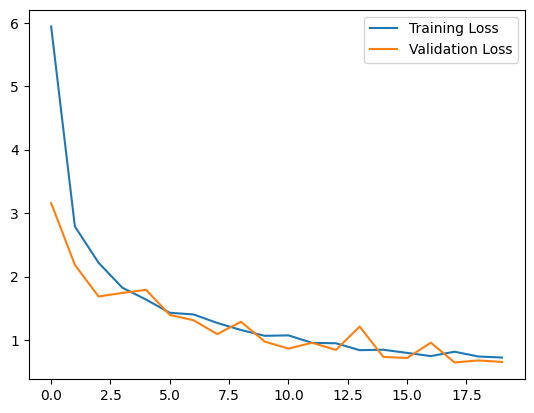

In [10]:
history = auto.fit(train_arr, train_arr, epochs=20, shuffle=True, validation_data=(test_arr, test_arr), batch_size=10)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])

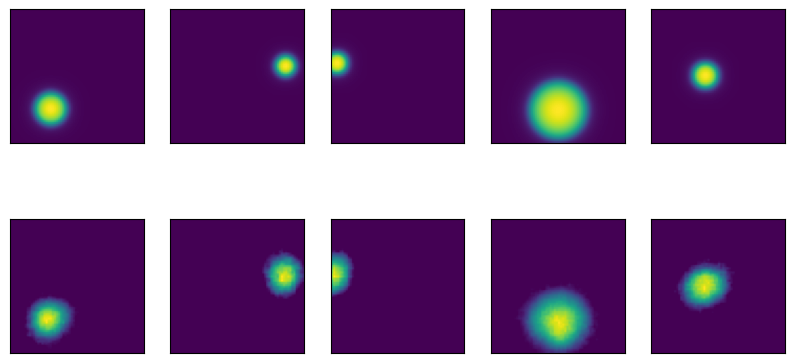

In [11]:
plt.rcParams['figure.figsize'] = [10, 5]
IMGS = 5
for n in range(IMGS):
    i = np.random.randint(test_arr.shape[0])
    inp = train_arr[i:i+1,:,:,:]
    out = auto(inp).numpy()
    plt.subplot(2, IMGS, n + 1)
    fig = plt.imshow(np.squeeze(inp))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.subplot(2, IMGS, n + IMGS + 1)
    fig = plt.imshow(np.squeeze(out))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

## Video Frame Predictor
Stacking 2 TransformerEncoder yielded better results, but going up to 3 seems to be too much for my training configuration.

In [98]:
from tensorflow.keras.layers import Dropout, Normalization, Flatten

class TransformerEncoder(Layer):
    def __init__(self, heads=3):
        super().__init__()
        self.heads = heads
    
    def build(self, input_shape):
        
        # self.att1 = SingleAttention(6, 6)
        self.multi1 = MultiAttention(6, 6, self.heads)
        
        self.drop = Dropout(0.2)
        
        self.norm1 = Normalization()
        self.norm2 = Normalization()
        
        self.dense1 = Dense(6, activation="relu")
    
    def call(self, xt):        
        x = self.multi1((xt,xt,xt))
        x = self.drop(x)
        
        x = tf.math.add(x, xt)
        x = self.norm1(x)
        x = self.dense1(x)
        
        x = tf.math.add(x, xt)
        x = self.norm2(x)
        
        return x

class VideoFramePredictor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.time_embedder = Time2Vector(9)
        
        self.te1 = TransformerEncoder(5)
        self.te2 = TransformerEncoder(3)
        
        self.dense1 = Dense(4, activation="relu")
        self.flat = Flatten()
    
    def call(self, x):
        time_vec = self.time_embedder(x)
        
        x = tf.concat([x, time_vec], axis=2)
        
        x = self.te1(x)
        x = self.te2(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = tf.expand_dims(x, axis=1)
        return x

In [101]:
te = VideoFramePredictor()
te.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())

### Data Generation

In [21]:
te_train_x = []
te_train_y = []
for i in range(1000):
    clear_output(wait=True)
    display(i)
    dataset.update()
    images = dataset()
    images = [ img.to_numpy().__array__() for img in images ]
    
    
    x = auto.encoder(np.stack(images[0:-1]))
    y = auto.encoder(np.expand_dims(images[-1], axis=0))
    
    te_train_x.append(x)
    te_train_y.append(y)

te_train_x = np.stack(te_train_x)
te_train_y = np.stack(te_train_y)

te_images  = []
te_test_x = []
te_test_y = []
for i in range(10):
    clear_output(wait=True)
    display(i)
    dataset.update()
    images = dataset()
    images = [ img.to_numpy().__array__() for img in images ]
    
    x = auto.encoder(np.stack(images[0:-1]))
    y = auto.encoder(np.expand_dims(images[-1], axis=0))
    te_images.append(images)
    
    te_test_x.append(x)
    te_test_y.append(y)
    
te_test_x = np.stack(te_test_x)
te_test_y = np.stack(te_test_y)

9

### Training

In [ ]:
print(te_train_x.shape, te_train_y.shape, te_test_x.shape, te_test_y.shape, len(te_images))

history = te.fit(te_train_x, te_train_y, epochs=50, shuffle=True, validation_data=(te_test_x, te_test_y), batch_size=10)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])

(1000, 9, 4) (1000, 1, 4) (10, 9, 4) (10, 1, 4) 10
Epoch 1/50
100/100 [==============================] - 8s 17ms/step - loss: 294.6936 - val_loss: 317.1285
Epoch 2/50
100/100 [==============================] - 1s 14ms/step - loss: 274.0849 - val_loss: 329.6766
Epoch 3/50
100/100 [==============================] - 1s 14ms/step - loss: 269.7898 - val_loss: 286.8276
Epoch 4/50
100/100 [==============================] - 1s 14ms/step - loss: 259.6469 - val_loss: 322.4331
Epoch 5/50
100/100 [==============================] - 1s 14ms/step - loss: 250.5088 - val_loss: 299.8233
Epoch 6/50
100/100 [==============================] - 1s 14ms/step - loss: 232.2195 - val_loss: 291.7090
Epoch 7/50
100/100 [==============================] - 1s 14ms/step - loss: 225.0628 - val_loss: 276.4158
Epoch 8/50
100/100 [==============================] - 1s 14ms/step - loss: 216.8284 - val_loss: 204.6223
Epoch 9/50
100/100 [==============================] - 1s 14ms/step - loss: 198.3269 - val_loss: 166.0719
Epoc

### Visualisation

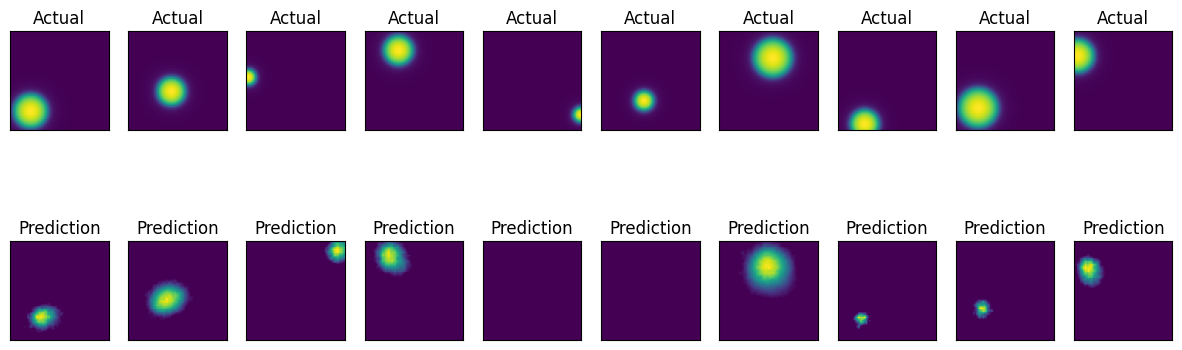

In [97]:
plt.rcParams['figure.figsize'] = [15, 5]
upper_lim = len(te_images)
for j in range(upper_lim):
    out = te(te_test_x[j:j+1,:,:])

    out_img = np.squeeze(auto.decoder(out[0,:,:]))

    plt.subplot(2,upper_lim, j + 1)
    fig = plt.imshow(te_images[j][9])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title("Actual")
    
    plt.subplot(2,upper_lim, upper_lim + j + 1)
    fig = plt.imshow(out_img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title("Prediction")